# How Platform, Publisher, and Genre affect North American video game sales

5/12/24

By: Mark Roland Garban and Stephen Gerloff

## Introduction

We're trying to predict global video game sales using information like genre, platform, publisher, developer, and the rating of the game. The video game industry, valued in the billions of dollars, has experienced rapid growth over the years. This expansion presents unique challenges and opportunities for game developers, publishers, and marketers, who makes strategic approaches to maximize North American video game sales and profitability.
We aim to tackle several important issues: predicting sales based on game characteristics, analyzing the effects of genres and platforms on success, and pinpointing the best marketing and release strategies. These insights are vital for stakeholders looking to boost their market presence and gain a competitive edge in this dynamic industry.


The video game sales data used within this project was uploaded to kaggle.com with the following url: https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset/data. The data comes from a web scrape of metacritic (a popular video game scoring website) and spans from the years 1980 to 2020. The data includes: The name of the video game that released, the platform it released on, the video games publisher, and the global sales of the game among other variables relating to how well the video game scored among users and critics. Even though most of the video games in this data set don't include current generation consoles, we have used this past data to give insight into how various aspects of a game release can relate to how well they sell.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn import tree
import graphviz

## Initial Data Exploration

Although the data was downloaded from kaggle.com, we have uploaded the raw data to github in order to make sure it is easily imported into Google Colab.

In [ ]:
url = "https://raw.githubusercontent.com/Stebanoe/Video-Game-Sales-Data/main/Video_Games_Sales_as_at_22_Dec_2016.csv?token=GHSAT0AAAAAACRZA3QBKSWFDKBGJBP76WRAZRT3H7A"
df = pd.read_csv(url)

Here is a look at all the variables within the data set:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


We can see that there is a total of 16 variables, with 6 of these containing object types and the others containing floats. We also see that there are a total of 16,719 rows to this data set, and some of the variables relating to how the game scores (such as Critic_Score and Critic_Count) have lots of missing values as they have a significantly lower count than the amount of rows.

What variables have the highest percentage of missing values?

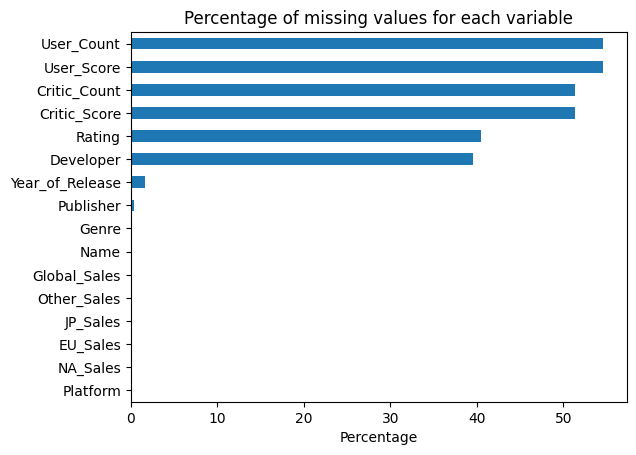

In [ ]:
(df.isna().mean()*100).sort_values().plot.barh()
plt.title("Percentage of missing values for each variable")
plt.xlabel("Percentage");

As mentioned above, many of the variables related to how a game scores have a significant amount of NA values as more than half of their values are missing. However, it is interesting to see that developer also has a large amount of NA values.

In [ ]:
df['NA_Sales'].describe().round(3)

count    16719.000
mean         0.263
std          0.814
min          0.000
25%          0.000
50%          0.080
75%          0.240
max         41.360
Name: NA_Sales, dtype: float64

When we look at a description of North American sales, we see that the average earning is around 0.26 million dollars, the median sale number is 0.08 million dollars,  and the maximum value is 41.36 million dollars. Because of this, it seems like the mean is being skewed by large values towards the top end of sales which most likely includes the maximum value mentioned before. However, both the minimum and 25% percentile values are 0, indicating that there are lots of games that were not sold in North America.

Lets see what the distribution of the top 10 most common sales numbers in North America look like.

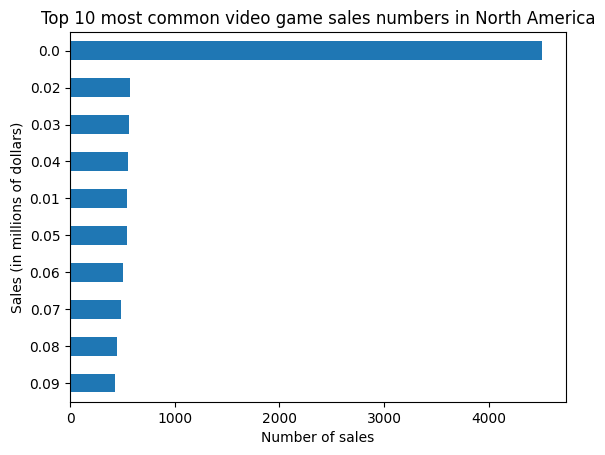

In [ ]:
df["NA_Sales"].value_counts().head(10).sort_values().plot.barh()
plt.title("Top 10 most common video game sales numbers in North America")
plt.ylabel("Sales (in millions of dollars)")
plt.xlabel("Number of sales");

We can see that there is an overwhelming amount of video games that were not sold in North America. Since there are over 4000 values that are equal to 0, these will need to be removed in order to only observe games that were released in this continent.

What years have had the most games release?

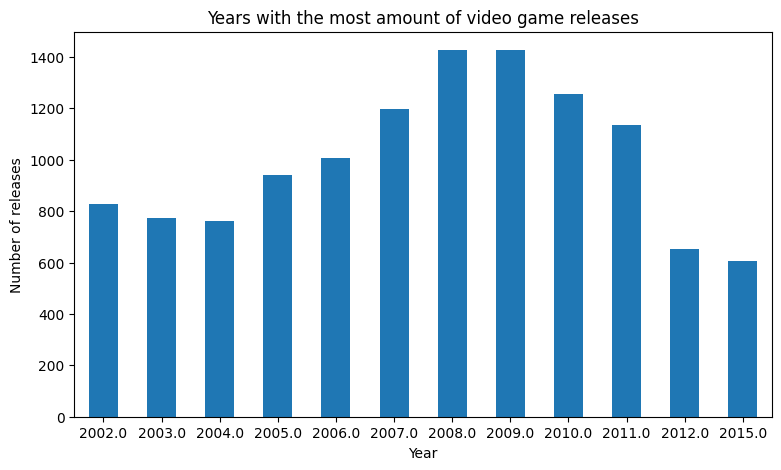

In [ ]:
df["Year_of_Release"].value_counts().head(12).sort_index().plot.bar(rot = 0, figsize = (9,5))
plt.title("Years with the most amount of video game releases")
plt.xlabel("Year")
plt.ylabel("Number of releases");

We can see that most of the video games that have released were between the years 2008 and 2009. They increased from 2002, but then started decreasing after the year 2009. This could mean that less video games were releasing, or it could mean that this is where most of the data within the dataset lies.

How many unique platforms, video game genres, and publishers are in this data set?

In [ ]:
print(f"Number of Unique Platforms: {df['Platform'].nunique()}")

Number of Unique Platforms: 31


There are a total of 31 different platforms within this data set.

In [ ]:
print(f"Number of Unique Genres: {df['Genre'].nunique()}")

Number of Unique Genres: 12


There are 12 unique video game genres present.

In [ ]:
print(f"Number of Unique Publishers {df['Publisher'].nunique()}")

Number of Unique Publishers 582


Finally, there are a total of 582 unique publishers which will need to be condensed as many of these more than likely only have a few games released or are no longer in operation and would not be indicative of a good publisher.

What publishers have published the most video games?

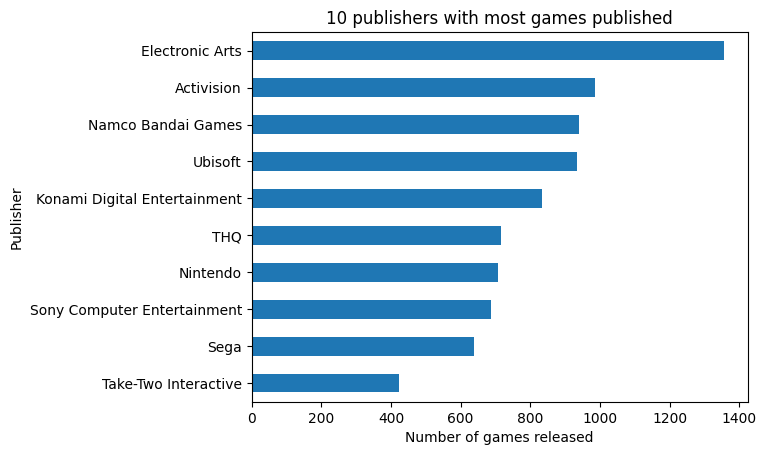

In [ ]:
df['Publisher'].value_counts().head(10).sort_values().plot.barh()
plt.title("10 publishers with most games published")
plt.xlabel("Number of games released");

Here we can see that a large amount of the games were published by Electronic Arts and Activision, with Electronic Arts having almost 400 more games published than Activision. However, Activision, Namco Bandai Games, and Ubisoft seen to all have around the same amount of published games.

What platforms have had the most games released for them?

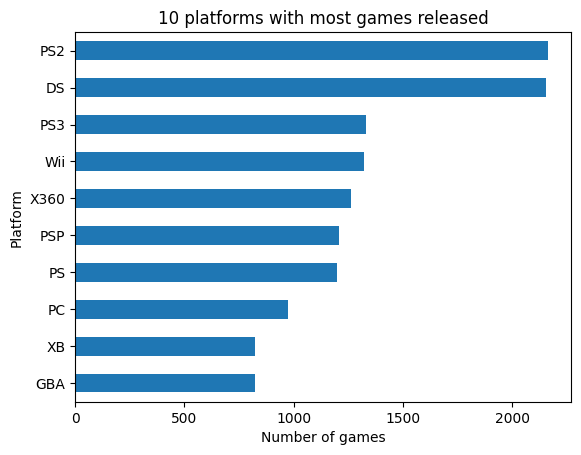

In [ ]:
df['Platform'].value_counts().head(10).sort_values().plot.barh()
plt.title("10 platforms with most games released")
plt.xlabel("Number of games");

When it comes to platform, DS and PS2 have the most amount of games compared to the other consoles by a wide margin. Although these consoles are dated, it shows how popular they were in the video game market when they were in their prime.

What is the most popular video game genre for a video game to release in?

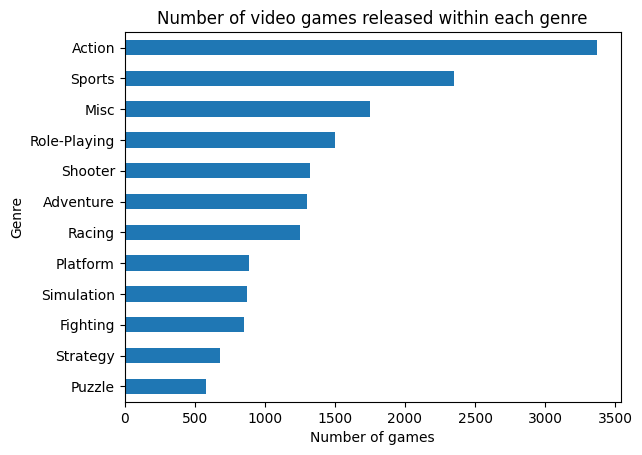

In [ ]:
df['Genre'].value_counts().sort_values().plot.barh()
plt.title("Number of video games released within each genre")
plt.xlabel("Number of games");

Out of all the genres, action games are the most popular while puzzle games are the least. This could be because action games have a wider diversity of games than puzzle, or it could be because these games are more popular and are more likely to sell in large amounts.

## Data Preprocessing

As mentioned before, many of the score-related variables had a significant amount of NA values or are unnecessary to our analysis, so they have been dropped. These variables include those such as critic/user scores, the name of the video game, and how the game sells in other countries and globally as they are most likely not indicative of how a game sells in North America or are given after a game has released (such as critic score).

In [ ]:
df = df.drop(["Critic_Score", "Critic_Count", "User_Score", "User_Count", "Global_Sales", "EU_Sales","Other_Sales", "JP_Sales", "Name"], axis = 1)

We can also change the year of release variable to be a pandas time series variable.

In [ ]:
df["Year_of_Release"] = pd.to_datetime(df["Year_of_Release"], format = "%Y").dt.year

Since the developer variable has lots of values, we will keep the top 10 and then replace the other values with "Other".

In [ ]:
dev_other = df["Developer"].value_counts()[10:].index.tolist()
df["Developer"].replace(dev_other, "Other", inplace = True)

Additionally, the developer variable had over 6000 NA values, so these will be replaced with the value "Unknown".

In [ ]:
df["Developer"].fillna("Unknown", inplace = True)

The Rating variable has similar problems as the developer variable, so only the most popular variables will be kept and the others will replaced with the value "Other", and NA values will be replaced with the value "Unknown".

In [ ]:
ratings_other = df["Rating"].value_counts()[4:].index.tolist()
df["Rating"].replace(ratings_other, "Other", inplace = True)
df['Rating'].fillna("Unknown", inplace = True)

Now we can remove whatever NA values might be left in the dataset.

In [ ]:
df = df.dropna()

Since there were so many 0 values in the North American sales variable, we can remove them in order to only look at games that were sold in this country.

In [ ]:
df = df[df['NA_Sales'] != 0]

Since there are 582 unique publishers, we have decided to only include the top 10 publishers. There is a good chance that many of the publishers in this data set have only published a couple of games or are no longer in operation, and would not be indicative of a good publisher for a future game release. Because of this, the 10 most popular publishers have been kept, and the rest have been placed in a new publisher called "Other".

In [ ]:
pub_other = df["Publisher"].value_counts()[10:].index.tolist()
df["Publisher"].replace(pub_other, "Other", inplace = True)

In order to reduce the amount of video game platforms (consoles) present in this data set and to make machine learning more valuable for present day, we have replaced specific platform titles into the title of the company who created them (for example, "PS" and "PS4" are now titled "Sony") and the column is now titled "Platform_Manufacturer".

In [ ]:
nintendo = ["Wii", "NES", "GB", "DS", "SNES", "3DS", "N64", "GBA", "WiiU", "GC"]
microsoft = ["X360", "XOne", "XB", ]
sony = ["PS4", "PS", "PS3", "PS2", "PSP", "PSV"]
sega = ["GEN", "DC", "SAT", "SCD", "GG", "PCFX"]
other = ["WS", "NG", "TG16", "3DO", "2600"]
df["Platform"].replace(nintendo, "Nintendo", inplace = True)
df["Platform"].replace(microsoft, "Microsoft", inplace = True)
df["Platform"].replace(sony, "Sony", inplace = True)
df["Platform"].replace(sega, "Sega", inplace = True)
df["Platform"].replace(other, "Other", inplace = True)
df.rename(columns = {"Platform" : "Platform_Manufacturer"}, inplace = True)

With our data preprocessed, we can now go into data exploration.

# Data Exploration

Given video game publisher, what is the probability they release a video game of a specific genre?

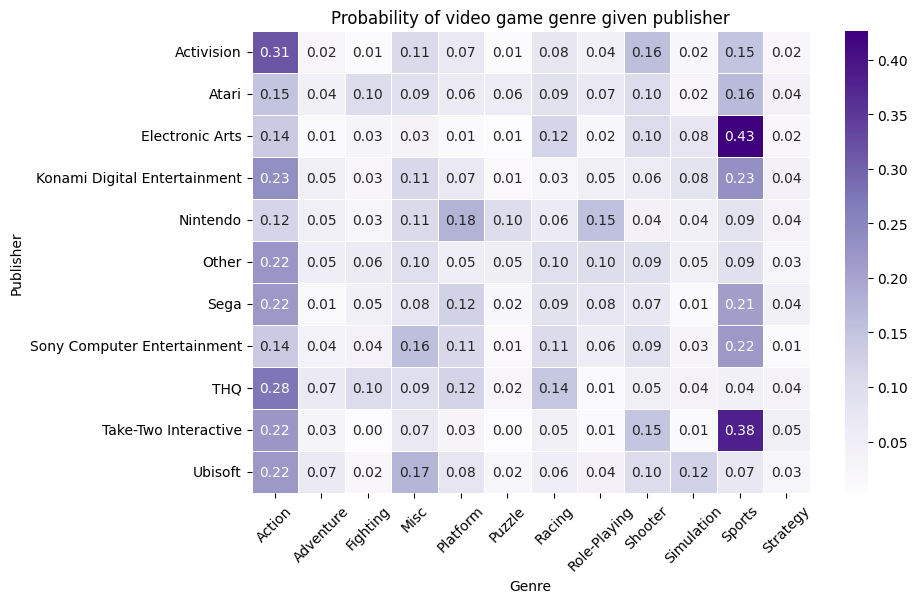

In [ ]:
plt.rcParams['figure.figsize'] = (9, 6)
Pub_top5 = df["Publisher"].value_counts()[1:6].index.tolist()
Genre_top5 = df["Genre"].value_counts().head(5).index.tolist()
ct = pd.crosstab(index = df["Publisher"], columns = df['Genre'], normalize = 'index')
sns.heatmap(ct, cmap = 'Purples', annot = True, fmt = '.2f', linewidth = 0.5)
plt.xticks(rotation = 45)
plt.title("Probability of video game genre given publisher");

Electronic Arts most popular game genre is Sports as seen by the high probability value. This is also the same for Konami Digital Entertainment and Take-Two Interactive which also have high values for sports. Activision and THQ mostly publish Action games while Ubisoft and Take-Two interactive also have slightly higher probability of publishing action games than every other genre. Nintendo has a higher probability of publishing a puzzle game than every other publisher as they have the only probability for that genre that is about 0.1.

What is the average global sale value for each platform manufacturer?

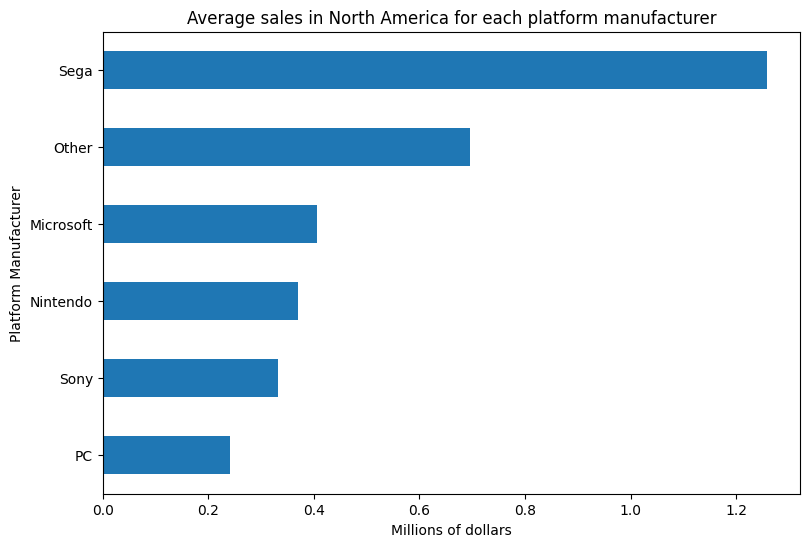

In [ ]:
df.groupby("Platform_Manufacturer")['NA_Sales'].mean().sort_values().plot.barh()
plt.title("Average sales in North America for each platform manufacturer")
plt.xlabel("Millions of dollars")
plt.ylabel("Platform Manufacturer");

Interestingly, Sega platforms had the highest average sales being about 1.2 million dollars on average, with "Other" platforms being the second highest at about 0.7 million dollars on average. This could be because most of the data in this dataset is fairly dated, as Sega has stopped making consoles since 2001. Even so, this shows how popular Sega consoles were in North America during their prime. Regardless, Microsoft platfroms have the third highest average sales at about 0.4 million dollars and PC has the lowest average sales with about 0.2 million dollars.

We can also take a look at how video game genre affects sales in North America.

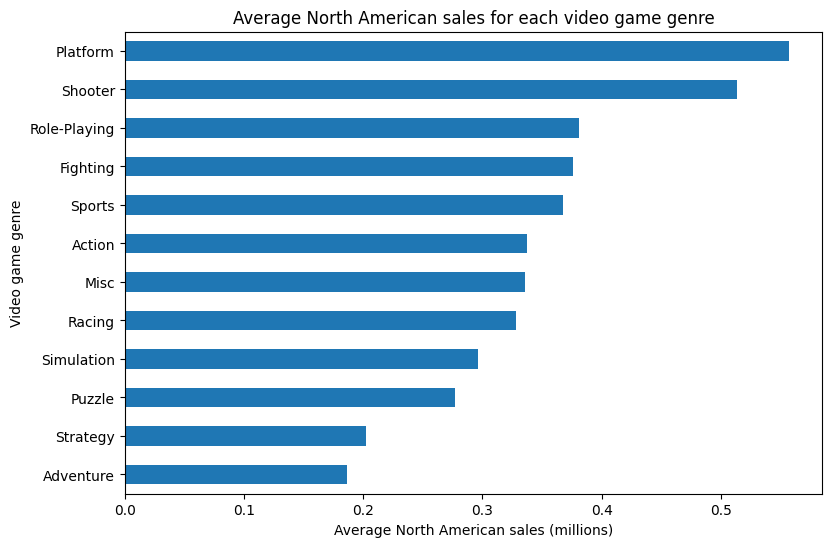

In [ ]:
df.groupby("Genre")["NA_Sales"].mean().sort_values().plot.barh()
plt.title("Average North American sales for each video game genre")
plt.xlabel("Average North American sales (millions)")
plt.ylabel("Video game genre");

Platform games tend to make more money on average than all the other genres within North America, with shooter games being in a close second place. This could indicate that these two genres are more popular than the rest and sell more as a result, or could be more expensive than games of other genre types. Adventure has the lowest average sales number, meaning that this would not be the best genre to release a new game in according to our data set.

How have video games sales changed over time in North America?

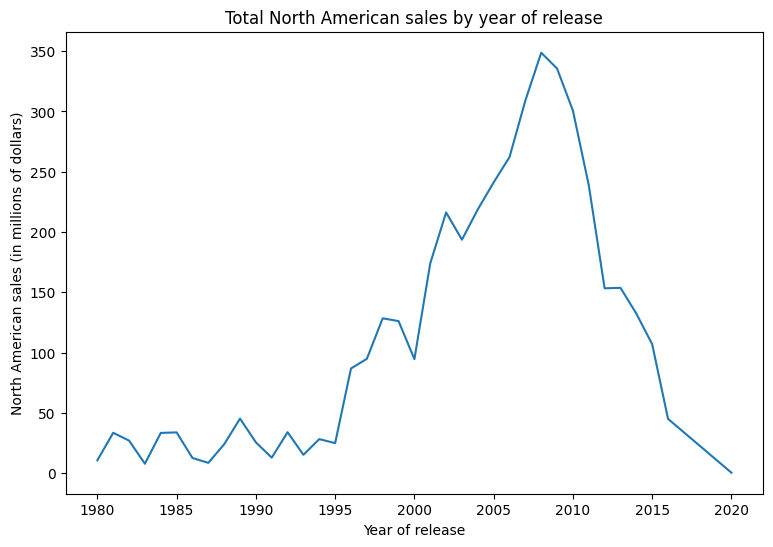

In [ ]:
df.groupby('Year_of_Release')['NA_Sales'].sum().plot.line()
plt.title('Total North American sales by year of release')
plt.xlabel('Year of release')
plt.ylabel('North American sales (in millions of dollars)')
plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
plt.show()

We see that North American sales started increasing extremely fast after the year 1995 until around the year 2008. After this, the sales number decrease until the year 2020. This is most likely due to the fact that most of the data within this dataset occurs between 2008 and 2009, and as a result there are less overall sales numbers for years that follow this.

## Machine Learning

### Preprocessing

Now we can prepare our data for machine learning by creating dummy variables

In [ ]:
df = pd.get_dummies(df, drop_first = True)

Choose our target and predictor variables and convert them into NumPy arrays. Additionally, we can perform a train/test split to get our training and testing data.

In [ ]:
target = "NA_Sales"
predictors = list(df.drop(["NA_Sales", "Year_of_Release"], axis = 1).columns)

X = df[predictors].values
y = df[target].values

Lets take a look at the size of our predictor and target variables

In [ ]:
print(X.shape)
print(y.shape)

(11970, 42)
(11970,)


In total, we have just under 12,000 rows of data and 42 predictor variables to work with. With this in mind, lets create a train/test split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

Additionally, baseline MAE was computed to observe how accurate the model would be if it just predicted the average value for global sales every time.

In [ ]:
mean_target = y_train.mean()
mae_baseline = np.abs(mean_target - y_train).mean()
print(f"Baseline MAE: {mae_baseline:0.3f}".format())

Baseline MAE: 0.379


### Decision Tree Regressor

Lets create our decision tree regressor model and see how it compares to our baseline value.

In [ ]:
reg = DecisionTreeRegressor(random_state = 0)
reg.fit(X_train, y_train)
cv_mae = -cross_val_score(reg, X_train, y_train,scoring='neg_mean_absolute_error', cv=10).mean()
print(f"Cross-validation MAE for decision tree regressor: {cv_mae:0.3f}")

Cross-validation MAE for decision tree regressor: 0.343


We can immediately see that our model is better than our baseline. However, since we want the best model possible, we can use a grid search to tune our hyperparameters.

In [ ]:
reg = DecisionTreeRegressor(random_state = 0)
grid = [{"max_depth" : range(10,21),
        "min_samples_leaf" : range(1,10),
        "max_features" : ['sqrt', None]}]
reg_cv = GridSearchCV(reg, grid, cv=10, scoring = "neg_mean_absolute_error")
reg_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=0),
             param_grid=[{'max_depth': range(10, 21),
                          'max_features': ['sqrt', None],
                          'min_samples_leaf': range(1, 10)}],
             scoring='neg_mean_absolute_error')

Lets see what the grid search used to create the best possible model.

In [ ]:
print(reg_cv.best_params_)

{'max_depth': 15, 'max_features': None, 'min_samples_leaf': 7}


We can see that grid search found that a max depth of 16, a max features of "None", and a min samples leaf value of 7 created the model with the best fit.

What was the best score we found from the grid search?

In [ ]:
print(f"Best MAE for decision tree regressor: {-reg_cv.best_score_:0.3f}")

Best MAE for decision tree regressor: 0.338


We can see that our tuned model found a much better MAE value than our baseline and a slightly better score than our base. Because of this, we can use our best hyperparameters to tune our model to make it an even better fit for our data.

### Linear Regression




We can now create and fit our linear model to our data with polynomial features.

In [ ]:
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)

LinearRegression()

Now that our model is created, we can take a look at how the parameters compare to each other.

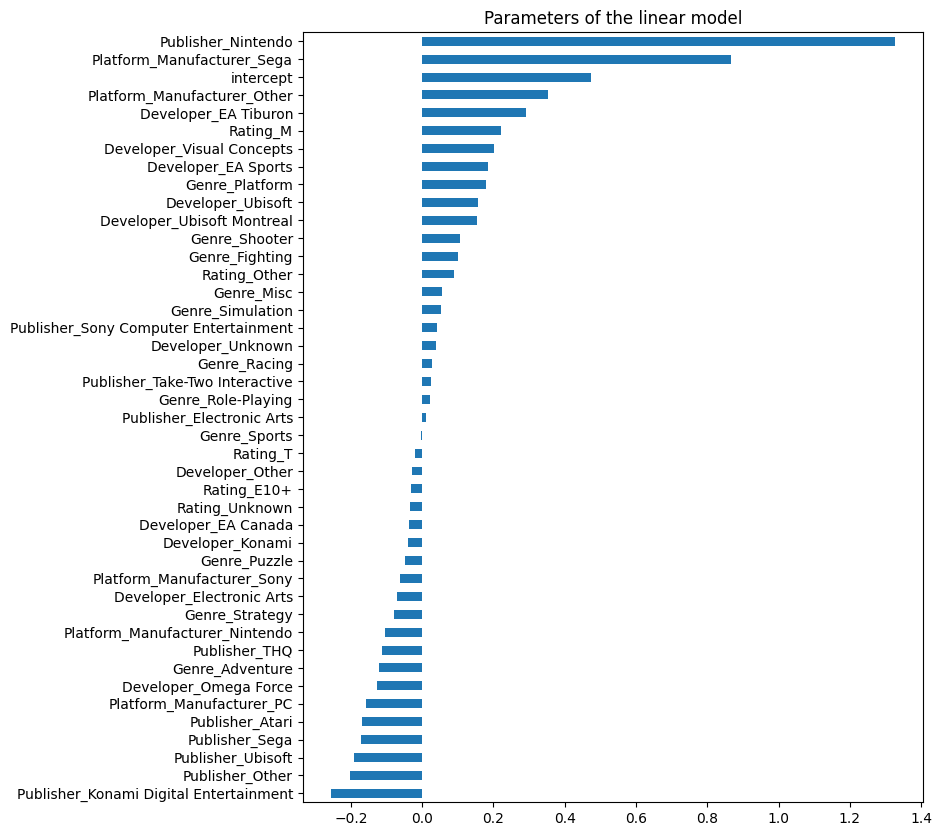

In [ ]:
intercept = pd.Series({"intercept":lin_regr.intercept_})
coefficients = pd.Series(lin_regr.coef_, predictors)
params = pd.concat([intercept, coefficients])

params.sort_values().plot.barh(figsize = (8,10))
plt.title("Parameters of the linear model");

There seems to be an even split between paramaters that have a positive coefficient and parameters that don't. The largest parameter by far is the publisher Nintendo, which could indicate that games released by this publisher have a large impact on how a video game sells in North America. Additionally, having a high intercept indicates that most game sales start relatively high in the model and can be decreased based on the negative parameters. Interestingly, the publisher Namco Bandai games has the largest negative coefficient value in our model, even lower than that of the other publishers parameter while the role playing genre has basically no impact on the model.

What is our cross-validation MAE value for the linear regression?

In [ ]:
cv_mae = -cross_val_score(lin_regr, X_train, y_train,scoring='neg_mean_absolute_error', cv=10).mean()
print(f"Cross-validation MAE for linear regression: {cv_mae:0.3f}")

Cross-validation MAE for linear regression: 0.346


Compared to our baseline values, our model seems to have improved. However, the decision tree regression model has a smaller MAE, indicating that it is a more appropriate model for our data than linear regression.

Lets create polynomial features and a new train/test split to see if they improve our MAE score for linear regression.

In [ ]:
pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly = pf.transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size = 0.3)

Now that our polynomial features have been created, we can fit our linear model to these new values.

In [ ]:
lin_regr.fit(X_train_poly, y_train)

LinearRegression()

Did this make any improvement to our MAE score?

In [ ]:
cv_mae = -cross_val_score(lin_regr, X_train_poly, y_train,scoring='neg_mean_absolute_error', cv=10).mean()
print(f"Cross-validation MAE for linear regression with polynomial features: {cv_mae:0.3g}")

Cross-validation MAE for linear regression with polynomial features: 2e+09


With polynomial features, we get an absurdly high MAE score, which could be indicative of overfitting. Either way, using these factors is not appropriate to get a better model.

### KNN Regression

Additionally, we can create a KNN Regression model to see if it has an even better fit than the previous model. First, we need to scale and fit our data to the model.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

Now that our data has been fit, scaled, and the hyper parameters have been tuned, so we can make our prediction.

In [ ]:
cv_mae = -cross_val_score(knn, X_train, y_train,scoring='neg_mean_absolute_error', cv=10).mean()
print(f"Cross-validation MAE for KNN regression: {cv_mae:.03f}".format())

Cross-validation MAE for KNN regression: 0.362


The cross-validation MAE for this model is larger than the others, so lets see how k need to be tuned and if that will give a better score.

In [ ]:
grid_knn = [{'n_neighbors': range(45, 56)}]
knnCV = GridSearchCV(knn, grid_knn, cv=10, scoring='neg_mean_absolute_error')
knnCV.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': range(45, 56)}],
             scoring='neg_mean_absolute_error')

What are is the best k value from this grid search?

In [ ]:
print(knnCV.best_params_)

{'n_neighbors': 54}


The best k value from this search is 54, so what is our new cross-validation MAE with this tuned model?

In [ ]:
print(f"Cross-validation MAE for KNN regression: {-knnCV.best_score_:.03f}".format())

Cross-validation MAE for KNN regression: 0.332


Our cross-validation MAE has improved significantly from the baseline and from the decision tree regression model, which could indicate that this is the best model to go forward with.

### Results

As a reminder, here is our baseline MAE:

In [ ]:
mean_target = y_train.mean()
mae_baseline = np.abs(mean_target - y_train).mean()
print(f"Baseline MAE: {mae_baseline:0.3f}".format())

Baseline MAE: 0.379


How does our test MAE compare for our tuned decision tree regressor model?

In [ ]:
reg = DecisionTreeRegressor(max_depth = 15, max_features = None, min_samples_leaf = 5, random_state = 0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mae = np.abs(y_pred - y_test).mean()
print(f"Test MAE for tuned decision tree regressor: {mae:0.3f}")

Test MAE for tuned decision tree regressor: 0.328


The test MAE for our tuned decision tree regressor is much better than our baseline and is even better than the best score that our gridsearch found, showing that this model is fairly appropriate for predicting North American sales.

How does our linear regression compare to our baseline?

In [ ]:
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test).mean()
mae = np.abs(y_pred - y_test).mean()
print(f"Test MAE for linear regression model: {mae:0.3f}")

Test MAE for linear regression model: 0.367


Our test MAE for the linear regression model is slightly better than the baseline, but is not better than the decision tree regressor. This indicates that this model is not as appropriate for predicting North American sales.

Finally, how does our KNN regression model compare to our baseline and our other models?

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 54)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mae = np.abs(y_pred - y_test).mean()
print(f"Test MAE for KNN regression model: {mae:0.3f}")

Test MAE for KNN regression model: 0.326


Our KNN regression model has a much better test MAE score than both the baseline and linear regression values. However, it is slightly higher than the decision tree regressor model so it might not be as good of a fit for predicting North American sales. Regardless, it is such a small difference that both models are likely to be just as appropriate as each other.

# Conclusions

In conclusion our project to predict video game sales in North America showed that different machine learning models can be very useful. The KNN Regression model was the best choice, with a Test Mean Absolute Error (MAE) of 0.326, which was just a bit better than the Decision Tree Regressor Regression that had a Test MAE of 0.328. Both of these models did much better than our initial simple guess, which had a MAE of 0.379, and they also did better than the Linear Regression model, which had a Test MAE of 0.367. These results highlight the importance of model selection and hyperparameter tuning in optimizing predictive performance. Both the Decision Tree and KNN models could be good choices depending on what you need, like if you want a model that’s easy to understand for making decisions. It’s important to keep updating and improving our models as the video game market changes. Additionally, we discovered that platform games and games released on Sega consoles have the highest average sales in North America. However, this could be caused by most of the data being available before the year 2010 and is most likely not indicative how a future game release would sell in the current economy.